In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls
%cd gdrive/MyDrive/test_colab/ml_project2/src/

Mounted at /content/gdrive
gdrive	sample_data
/content/gdrive/MyDrive/test_colab/ml_project2/src


In [ ]:
!pip install --upgrade tf-keras-vis tensorflow matplotlib==3.1.0

     |████████████████████████████████| 320.4MB 56kB/s 
     |████████████████████████████████| 13.1MB 59.7MB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 3.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
# Mounting Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

# Keras modules
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, ZeroPadding2D, Dropout, BatchNormalization, Activation, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, RemoteMonitor, TensorBoard, ReduceLROnPlateau, History, EarlyStopping
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

from tensorflow.keras import backend
#import tensorflow.keras.backend as K
from tqdm.keras import TqdmCallback

#General
import numpy as np
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import glob
import datetime
import os
import pickle
from scipy.stats import mode
import tarfile
from tqdm import tqdm
import datetime
import math

In [ ]:
! git reset --hard 
! git pull

Checking out files: 100% (2387/2387), done.
HEAD is now at 076018f clinical databases
Already up to date.


In [ ]:
#Our Modules
import sound_processing as sp
from utils import*

In [ ]:
!ls -l ../pneumoscope/npz_files/*/

../pneumoscope/npz_files/GVA/:
total 3079312
-rw------- 1 root root  553904757 Nov 27 16:23 GVA_Ca_Co_test.npz
-rw------- 1 root root 1369343627 Nov 27 16:16 GVA_Ca_train_b1.npz
-rw------- 1 root root 1229965595 Nov 27 16:13 GVA_Co_train_b1.npz

../pneumoscope/npz_files/POA/:
total 21056243
-rw------- 1 root root  546407225 Nov 28 07:42 POA_Ca_Co_test.npz
-rw------- 1 root root 4121620181 Nov 27 15:29 POA_Ca_train_b1.npz
-rw------- 1 root root 4301549167 Nov 27 15:17 POA_Ca_train_b2.npz
-rw------- 1 root root 4519848135 Nov 27 15:41 POA_Ca_train_b3.npz
-rw------- 1 root root 4150727343 Nov 27 15:52 POA_Ca_train_b4.npz
-rw------- 1 root root 3088366560 Nov 27 16:07 POA_Co_train_b1.npz
-rw------- 1 root root  833071644 Nov 27 15:57 POA_Co_train_b2.npz


In [ ]:
def get_GVA():

  # Train -------------------------------------
  feat_GVA_Ca, _, posi_GVA_Ca, ctrl_GVA_Ca, _, nbpa_GVA_Ca = load_from_npz( '../pneumoscope/npz_files/GVA/GVA_Ca_train_b1.npz' )
  feat_GVA_Co, _, posi_GVA_Co, ctrl_GVA_Co, _, nbpa_GVA_Co = load_from_npz( '../pneumoscope/npz_files/GVA/GVA_Co_train_b1.npz' )
  # Merge train batches -----------------------
  features   = np.append(feat_GVA_Ca, feat_GVA_Co)
  positions  = np.append(posi_GVA_Ca, posi_GVA_Co)
  controls   = np.append(ctrl_GVA_Ca, ctrl_GVA_Co)
  patientnbs = np.append(nbpa_GVA_Ca, nbpa_GVA_Co)

  # Test ---------------------------------------
  feat_GVA_test, _, posi_GVA_test, ctrl_GVA_test, _, nbpa_GVA_test = load_from_npz( '../pneumoscope/npz_files/GVA/GVA_Ca_Co_test.npz'  )
  featuresT   = feat_GVA_test
  positionsT  = posi_GVA_test
  controlsT   = ctrl_GVA_test
  patientnbsT = nbpa_GVA_test

  # return (train),(test)
  return (features, positions, controls, patientnbs), (featuresT, positionsT, controlsT, patientnbsT)

In [ ]:
def get_POA(shrink = True, batch=1):

  # Train -------------------------------------
  feat_POA_Ca, _, posi_POA_Ca, ctrl_POA_Ca, _, nbpa_POA_Ca = load_from_npz( '../pneumoscope/npz_files/POA/POA_Ca_train_b' + str(batch) + '.npz' )
  try:
    feat_POA_Co, _, posi_POA_Co, ctrl_POA_Co, _, nbpa_POA_Co = load_from_npz( '../pneumoscope/npz_files/POA/POA_Co_train_b' + str(batch) + '.npz' )
  except:
    batch = np.random.choice([1, 2])
    feat_POA_Co, _, posi_POA_Co, ctrl_POA_Co, _, nbpa_POA_Co = load_from_npz( '../pneumoscope/npz_files/POA/POA_Co_train_b' + str(batch) + '.npz' )

  # Merge train batches -----------------------
  features   = np.append(feat_POA_Ca, feat_POA_Co)
  positions  = np.append(posi_POA_Ca, posi_POA_Co)
  controls   = np.append(ctrl_POA_Ca, ctrl_POA_Co)
  patientnbs = np.append(nbpa_POA_Ca, nbpa_POA_Co)

  # Test ---------------------------------------
  feat_POA_test, _, posi_POA_test, ctrl_POA_test, _, nbpa_POA_test = load_from_npz( '../pneumoscope/npz_files/POA/POA_Ca_Co_test.npz'  )
  featuresT   = feat_POA_test
  positionsT  = posi_POA_test
  controlsT   = ctrl_POA_test
  patientnbsT = nbpa_POA_test

  # Shrink too big features --------------------
  if (shrink):
    for i in range(featuresT.shape[0]):
      size = featuresT[i].shape[0]
      if (size > 20):
        idx = np.random.randint(size, size=15)
        featuresT[i] = featuresT[i][idx,:]
        #print(featuresT[i].shape)

    for i in range(features.shape[0]):
      size = features[i].shape[0]
      if (size > 20):
        idx = np.random.randint(size, size=15)
        features[i] = features[i][idx,:]

  # return (train),(test)
  return (features, positions, controls, patientnbs), (featuresT, positionsT, controlsT, patientnbsT)

In [ ]:
def stack_pos_new(patients, features, controls, positions, patientnbs):
    x = []
    y = []
    patient_id = []

    uniq_id = np.unique(np.dstack((controls.astype('|S4'), patientnbs.astype('|S4'))), axis=1)[0, :, :]
    for (caco, pnb) in uniq_id:
        indx_initial = (controls.astype('|S4') == caco) & (patientnbs.astype('|S4') == pnb)

        x_data, y_data, train_patientnb_big, train_position_big = prepare_samples(features[indx_initial],
                                                                                  controls[indx_initial],
                                                                                  positions[indx_initial],
                                                                                  patientnbs[indx_initial],
                                                                                  shuffle=False, extractor=lambda s:
            sp.features_extraction(s, 22050, 'stft', lower_limit = 20))


        shape = x_data[0].shape
        freq = mode(train_position_big)  # returns the position with the most crops and the number of crops
        for i in range(0, freq[1][0]):
            # for each patient we make the x number of data points where x is the frequency of the most reoccurring position
            sample = np.empty(shape)  # initialize empty array
            for p in range(1, 9):  # iterate through positions
                pos = 'P' + str(p)
                if pos != freq[0][0]:  # if position is not the most reoccurring position
                    indx = np.argwhere(train_position_big == pos).flatten()  # return the indices of these positions
                    try:  # if position is present , stack
                        try:  # append available crops first
                            sample = np.dstack([sample, x_data[indx[i]]])
                        except:  # once we run out of them take any random one
                            sample = np.dstack([sample, x_data[np.random.choice(indx)]])
                            # randomly take any available crops for this position and stack depthwise
                    except:  # if position not available fill the layer with zeros
                        sample = np.dstack([sample, np.zeros(shape)])
                else:  # if the position is the most reoccuring one
                    indx = np.argwhere(
                        train_position_big == 'P' + str(p))  # return the indicies of the most reocurring body position

                    indx = indx.flatten()
                    patient_id.append(caco.decode('UTF-8') + pnb.decode('UTF-8'))   # list of unique pat id
                    sample = np.dstack([sample, x_data[indx[i]]])  # stack that body pos
                    y.append(controls[indx_initial][0] == 'Ca')  # append the label of the patient
            sample = np.delete(sample, 0, axis=2)  # delete the first row since it was used for initializing
            x.append(sample)  # append into train array

    patient_id = np.array(patient_id)
    x = np.array(x)
    y = to_categorical(np.array(y).astype(int))
    shuffle_indices = np.random.permutation(np.arange(y.shape[0]))

    return x[shuffle_indices], y[shuffle_indices], patient_id[shuffle_indices]

In [ ]:
def get_arrays(batch=1):
  print('Importing Data')
  (features, positions, controls, patientnbs), (featuresT, positionsT, controlsT, patientnbsT) = get_POA(batch=batch)
  print('Identifying Train and Test Patients')
  test_patients = np.unique(np.dstack(( controlsT.astype('|S4'),patientnbsT.astype('|S4') )),axis = 1) # identify the test patients
  train_patients = np.unique(np.dstack(( controls.astype('|S4'),patientnbs.astype('|S4')  )),axis = 1)
  print('There are ' + str(train_patients.shape[1]) + ' train patients')
  print('There are ' + str(test_patients.shape[1]) + ' test patients')

  print('Creating Training Data')
  x_train, y_train , _= stack_pos_new(train_patients, features, controls, positions, patientnbs) 
  print(x_train.shape)
  print('Creating Test Data')
  x_test, y_test ,_= stack_pos_new(test_patients, featuresT, controlsT, positionsT, patientnbsT)
  print(x_test.shape)

  return x_train, y_train , x_test, y_test

def get_arrays_GVA(batch=1):
  print('Importing Data')
  (features, positions, controls, patientnbs), (featuresT, positionsT, controlsT, patientnbsT) = get_GVA()
  print('Identifying Train and Test Patients')
  test_patients = np.unique(np.dstack(( controlsT.astype('|S4'),patientnbsT.astype('|S4') )),axis = 1) # identify the test patients
  train_patients = np.unique(np.dstack(( controls.astype('|S4'),patientnbs.astype('|S4')  )),axis = 1)
  print('There are ' + str(train_patients.shape[1]) + ' train patients')
  print('There are ' + str(test_patients.shape[1]) + ' test patients')

  print('Creating Training Data')
  x_train, y_train , _= stack_pos_new(train_patients, features, controls, positions, patientnbs) 
  print(x_train.shape)
  print('Creating Test Data')
  x_test, y_test ,_= stack_pos_new(test_patients, featuresT, controlsT, positionsT, patientnbsT)
  print(x_test.shape)

  return x_train, y_train , x_test, y_test


In [ ]:
print(stack_pos)
x_train, y_train, x_test, y_test = get_arrays(2)

<function stack_pos at 0x7f91770b40d0>
Importing Data
Importing from: ../pneumoscope/npz_files/POA/POA_Ca_train_b2.npz
Importing from: ../pneumoscope/npz_files/POA/POA_Co_train_b2.npz
Importing from: ../pneumoscope/npz_files/POA/POA_Ca_Co_test.npz
Identifying Train and Test Patients
There are 66 train patients
There are 8 test patients
Creating Training Data
(853, 20, 216, 8)
Creating Test Data
(100, 20, 216, 8)


In [ ]:
x_train_GVA, y_train_GVA, x_test_GVA, y_test_GVA = get_arrays_GVA(2)

Importing Data
Importing from: ../pneumoscope/npz_files/GVA/GVA_Ca_train_b1.npz
Importing from: ../pneumoscope/npz_files/GVA/GVA_Co_train_b1.npz
Importing from: ../pneumoscope/npz_files/GVA/GVA_Ca_Co_test.npz
Identifying Train and Test Patients
There are 69 train patients
There are 9 test patients
Creating Training Data
(1019, 20, 216, 8)
Creating Test Data
(196, 20, 216, 8)


# Model and Training

In [ ]:
def def_model(shape):
  dense = 25
  model = Sequential()

  #model.add(Convolution2D(3, (1, 1), activation='relu', padding='same', input_shape=shape, data_format='channels_last') )
  #model.add(BatchNormalization())
  #model.add(MaxPooling2D(2, 2))
  #model.add(Dropout(0.25))

  model.add(Convolution2D(15, (3, 3), activation='relu', padding='same', input_shape=shape, data_format='channels_last') )
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.25))

  model.add(Convolution2D(30, (3, 3), activation='relu', padding='same', input_shape=shape, data_format='channels_last'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.25))

  model.add(Convolution2D(5, (1, 1), activation='relu', padding='same', input_shape=shape, data_format='channels_last') )
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(0.25))


  model.add(Flatten())
  model.add(Dense(dense, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(2, activation='softmax'))
  
  return model
  


In [ ]:
def callbacks():

  checkpointer = ModelCheckpoint(monitor='val_loss', # automatically saves the model 
                               mode='auto', 
                               filepath= '../Etienne_checking.h5',
                               verbose=0,
                               save_best_only=True,
                               save_freq = 'epoch'
                              )

  lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, # can be used to reduce the learning rate once the model stops learning
                       min_delta=0.001, cooldown=1,
                       verbose=0, patience=10,
                        min_lr=4.0e-7)
  early = EarlyStopping(monitor='val_loss',
                        min_delta=0.002,
                        patience=20,
                        verbose=0,
                        mode='auto', 
                        baseline=None,
                        restore_best_weights=False
)


  return checkpointer, lr, early


In [ ]:
def train(x_train, y_train, x_test, y_test):

  shape = x_train.shape[1:]

  model = def_model(shape)

  sgd = optimizers.SGD(lr=0.00004, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', f1])

  checkpointer, lr, early = callbacks()
   
  train_batch_size = 32
  train_steps = x_train.shape[0]//train_batch_size # need to specify the number of steps since the data generator outputs continuously
  #FitTheModel

  history = model.fit(x_train, y_train,
                      steps_per_epoch=train_steps,
                      epochs=200,
                      validation_data=(x_test, y_test),
                      callbacks=[checkpointer, lr, TqdmCallback(verbose=0)],
                      verbose=0
                      )
  
  max_val_acc = max(history.history['val_accuracy'])
  min_val_loss = min(history.history['val_loss'])
  max_val_f1 = max(history.history['val_f1'])
  print('Min val_loss = {}, Max val_acc = {}, Max val_f1 = {}'.format(min_val_loss, max_val_acc, max_val_f1))
  print(type(model))
  return history


In [ ]:
def train_and_plot():
  history = train(x_train, y_train, x_test, y_test)
  plot_history(history)

train_and_plot()

KeyboardInterrupt: ignored

In [ ]:
!ls ../*.h5

# Model Evaluation

In [ ]:
import tensorflow
#model = def_model((20,200))

model = tensorflow.keras.models.load_model('../TRAIN_ON_CROPPED_POA_BATCH_2_RUN_2_-2020-12-05.h5', custom_objects={'f1': f1}, compile=False)
sgd = optimizers.SGD(lr=0.00004, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', f1])

NameError: ignored

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
print(f1(y_test,y_pred))

tf.Tensor(0.96999997, shape=(), dtype=float32)


In [ ]:
val = 3

y_pred[val] , y_test[val]

(array([0.8971171 , 0.10288291], dtype=float32),
 array([1., 0.], dtype=float32))

# LRP Analysis

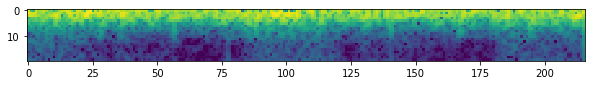

In [ ]:
#show input

input_analysed = x_test[val]

plt.imshow(input_analysed[:,:,0])
plt.show()

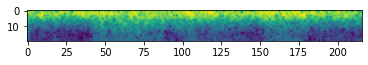

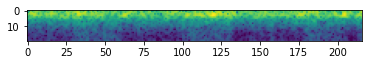

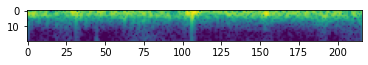

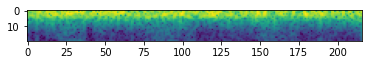

In [ ]:
# POA Control



for i in np.random.randint(100, size=10):
  if(y_test[i][0] == 1):
    input__o = x_test[i]
    plt.imshow(input__o[:,:,0])
    plt.savefig('pdf/POA_Co_'+str(i)+'.pdf')
    plt.show()

In [ ]:
!ls

graph.png	model_tools.py	POA_Co_75.pdf  __pycache__
main.ipynb	POA_Co_16.pdf	POA_Co_80.pdf  sound_processing.py
model_plot.png	POA_Co_1.pdf	POA_Co_90.pdf  utils.py
models		POA_Co_71.pdf	POA_Co_94.pdf


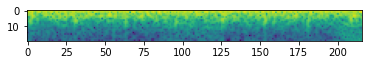

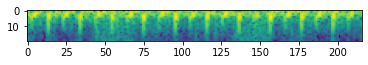

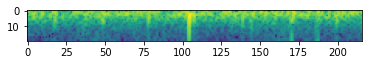

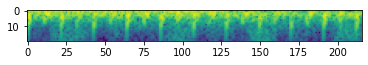

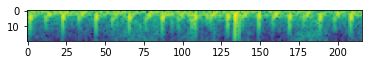

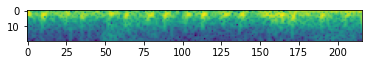

In [ ]:
#GVA Control
for i in np.random.randint(100, size=10):
  if(y_test_GVA[i][0] == 1):
    input__o = x_test_GVA[i]
    plt.imshow(input__o[:,:,0])
    plt.savefig('pdf/GVA_Co_'+str(i)+'.pdf')
    plt.show()

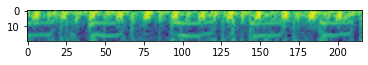

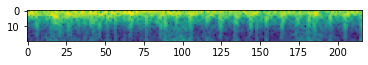

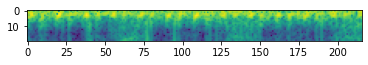

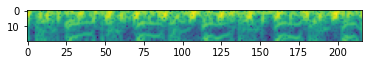

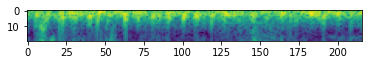

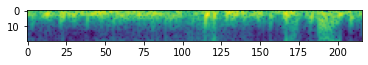

In [ ]:
# POA Ca

for i in np.random.randint(100, size=10):
  if(y_test[i][0] == 0):
    input__o = x_test[i]
    plt.imshow(input__o[:,:,0])
    plt.savefig('pdf/POA_Ca_'+str(i)+'.pdf')
    plt.show()

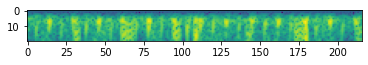

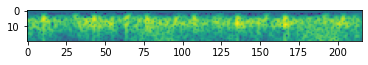

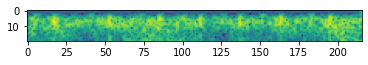

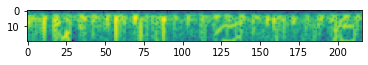

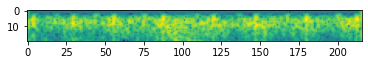

In [ ]:
# GVA

for i in np.random.randint(100, size=10):
  if(y_test_GVA[i][0] == 0):
    input__o = x_test_GVA[i]
    plt.imshow(input__o[:,:,0])
    plt.savefig('pdf/GVA_Ca_'+str(i)+'.pdf')
    plt.show()

In [ ]:
!mkdir pdf

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 216, 15)       1095      
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 216, 15)       60        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 108, 15)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 108, 15)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 108, 30)       4080      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 108, 30)       120       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 54, 30)        

In [ ]:
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


In [ ]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [ ]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Create Saliency object.
# If `clone` is True(default), the `model` will be cloned,
# so the `model` instance will be NOT modified, but it takes a machine resources.
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=False)

CPU times: user 252 µs, sys: 32 µs, total: 284 µs
Wall time: 603 µs


In [ ]:
X = np.array([ input_analysed  ])

def loss_0(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][0])
def loss_1(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    return (output[0][1])

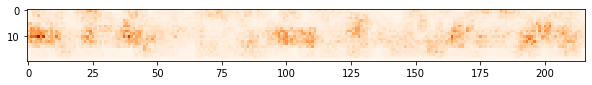

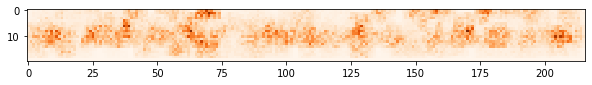

In [ ]:
# Generate saliency map
saliency_map = saliency(loss_0, X , smooth_samples=50,smooth_noise=0.01)
saliency_map = normalize(saliency_map)

plt.imshow(saliency_map[0], cmap='Oranges')
plt.show()

# Generate saliency map
saliency_map = saliency(loss_1, X , smooth_samples=50,smooth_noise=0.01)
saliency_map = normalize(saliency_map)

plt.imshow(saliency_map[0], cmap='Oranges')
plt.show()

In [ ]:
print(saliency_map.shape)

(1, 20, 216)


In [ ]:
input_analysed.shape

(20, 216, 8)

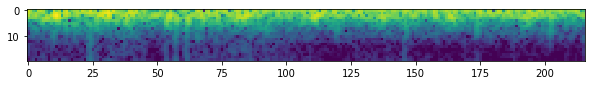

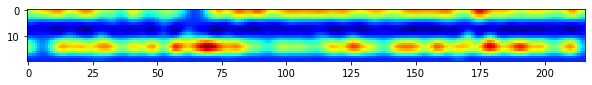

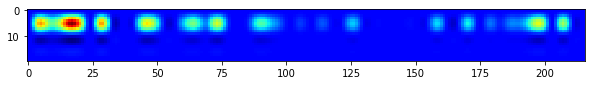

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss_0,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow( X[0][:,:,2])
plt.show()
plt.imshow(heatmap , cmap='Oranges')
plt.show()

# Generate heatmap with GradCAM
cam = gradcam(loss_1,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(heatmap , cmap='Oranges')
plt.show()